# Tutorial 2

# Imported modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import linalg

In [2]:
def output_banner():
    print(' Iter   Nfev     Step       Objective    Norm of g')


In [3]:
def output_iteration_info(k, nf, t, f, g):
    print('{0:5d} {1:6d} {2:10e} {3:10e} {4:10e}'.format(k, nf, t, f, linalg.norm(g, np.inf)))

In [4]:
def output_final_results(x, f, g, nf, ng, nh, k):   
    print('\n')
    print('          x:', x)
    print('        fun:', f)
    print('        jac:', g)
    print('norm of jac:', linalg.norm(g, np.inf))
    print('       nfev:', nf)
    print('       ngev:', ng)
    print('       nhev:', nh)
    print('        nit:', k)


## Example 1: The Rosenbrock function

### Objective

In [5]:
def objective(x):
    """
    Two-variable Rosenbrock function
    """
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

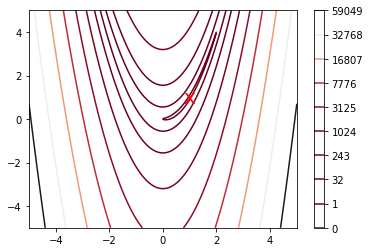

In [6]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)
Z = objective(np.vstack([X.ravel(), Y.ravel()])).reshape((1000,1000))
plt.contour(X, Y, Z, np.arange(10)**5, cmap='RdGy')
plt.colorbar();
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

### Gradient

In [7]:
def gradient(x):
    """
    Derivative of two-variable Rosenbrock function
    """
    return np.array([    
        400 * (x[0]**2 - x[1]) * x[0] + 2*(x[0]-1),
        200 * (x[1] - x[0]**2)
    ])

### Hessian

In [8]:
def hessian(x):
    """
    Hessian of two-variable Rosenbrock function
    """
    return np.array([
        [2 - 400 * (x[1] - 3 * x[0]**2), -400 * x[0]],
        [                   -400 * x[0],         200]
    ])

In [9]:
## Suggested initial iterates

In [10]:
# x0 = np.array([-1.2, -1.2])
# x0 = np.array([-1, 0.8])
# x0 = np.array([-1.2, 1])
# x0 = np.array([0.4, 0.2]  # start in convex region near the solution (from L. Roberts, Oxford University)
# x0 = np.array([-0.9, 1])  # start in nonconvex region (from L. Roberts, Oxford University)
x0 = np.array([-50, 40])  # start very far away (L. Roberts, Oxford University)

## The steepest descent method (See Tutorial 1)

In [11]:
def steepest_descent_AllInOne(objective, gradient, x0):
    """Implementation of the steepest descent method with a backtracking-Armino linesearch.
    Adapted from steepdes.m, a matlab script which has been around on the internet for a while.
    Written by Philip E. Gill (UCSD) and Walter Murray (Stanford) for pegadogic use.
    """

    kmax = 100000
    jmax = 2

    dxmax = 1

    c1 = .0001
    c1 = 1/4
    beta = .5
    x = x0.astype(float)
    f = objective(x); nf = 1
    g = gradient(x); ng = 1
    
    k = 1
    
    output_banner()
    
    while ((linalg.norm(g, np.inf) > 1e-6) and (k <= kmax)):
        d = -g
        t = min(1, dxmax/linalg.norm(g, np.inf))
        xnew = x + t * d
        fnew = objective(xnew); nf += 1
        j = 1
        while ((fnew > f + t * c1 * np.inner(g,d)) and (j <= jmax)):
            t = t * beta
            xnew = x + t * d
            fnew = objective(xnew); nf += 1
            j  += 1
        if j > jmax:
            print('Armijo failed to make progress')
            break

        if (k%100 == 1): output_iteration_info(k, nf, t, f, g)

        x = xnew
        f = fnew
        g = gradient(x); ng += 1
        k += 1

    if k > kmax:
        print('Steepest descent failed to converge after maxiter iterations')

    output_final_results(x, f, g, nf, ng, 0, k);
    return x, f, g


In [12]:
steepest_descent_AllInOne(objective,gradient,x0);

 Iter   Nfev     Step       Objective    Norm of g
    1      2 2.032516e-08 6.051626e+08 4.920010e+07
Armijo failed to make progress


          x: [-6.5        40.98882098]
        fun: 215.30725139505952
        jac: [-3294.06544526  -252.23580348]
norm of jac: 3294.065445261199
       nfev: 49
       ngev: 45
       nhev: 0
        nit: 45


# Algorithms

## Linesearches

### Armijo

In [13]:
def armijo(obj, grad, x0, f0, g0, t0, d, nf, ng):
    
    """ Backtracking-Armijo linesearch """

    c1 = 1e-4 
    
    iterMax = 20
    
    gtd0 = np.inner(g0,d)
    
    if (gtd0 >= 0):
        raise SystemExit("Armijo: Direction provided is not a descent direction.")
    
    t = t0

    for k in range(iterMax):
        x = x0 + t*d
        f = obj(x)
        if (f < f0 + c1*t*gtd0):
            g = grad(x)
            return x, f, g, t, nf + k + 1, ng + 1
        else:
            t = t/2
    
    raise SystemExit("Armijo: Maximum Iterations exceeded.")

### Wolfe

In [14]:
def wolfe(obj, grad, x0, f0, g0, t0, d, nf, ng):
    
    """
    """
    
    c1 = 1e-4
    c1 = 1/4
    c2 = 0.90
    
    iterMax = 100
    
    a  = 0
    b  = np.inf
    gtd0 = np.inner(g0,d)

    if (gtd0 >= 0):
        raise SystemExit("Wolfe: Direction not a descent direction.")

    t  = t0;

    for k in range(iterMax):
        x = x0 + t*d
        f = obj(x); nf += 1
        if (f > f0 + c1*t*gtd0):
            b = t
            t = (a+b)/2
        else:
            g = grad(x); ng += 1
            if (np.inner(g,d) < c2*gtd0):
                a = t
                if (b == np.inf):
                    t = 2*t
                else:
                    t = (a+b)/2
            else:
                return x, f, g, t, nf, ng
    

    raise SystemExit("WOLFE: Maximum Iterations exceeded.")

## Update Quasi-Newton Matrices 

In [15]:
def HUpdate_H(H, s, y):
    
    """ Updates matrix H 
    """


In [16]:
# Descent directions

## Steepest descent

In [17]:
def steepest_descent(objective, gradient, linesearch, x0):
    
    """Steepest gradient descent."""

    maxiter = 20000

    x = x0.astype(float)
    f = objective(x); nf = 1
    g = gradient(x); ng = 1
    
    dxmax = 1
    
    k = 0
    
    output_banner()
    
    while ((linalg.norm(g, np.inf) > 1e-6) and (k < maxiter)):
        t = min(1, dxmax/linalg.norm(g, np.inf))
        d = -g
        x, f, g, t, nf, ng = linesearch(objective, gradient, x, f, g, 1, d, nf, ng)
        k += 1
        if (k%100 == 1): output_iteration_info(k, nf, t, f, g)

    output_final_results(x, f, g, nf, ng, 0, k);
    return x, f, g, nf, ng, k;

In [18]:
steepest_descent(objective,gradient, wolfe, x0);

 Iter   Nfev     Step       Objective    Norm of g
    1     22 9.536743e-07 9.604342e+04 3.815846e+04
  101   1479 6.103516e-05 5.327596e+01 1.584472e+00
  201   2831 3.051758e-05 5.315028e+01 1.169756e+00
  301   4220 7.812500e-03 5.303353e+01 1.905140e+01
  401   5678 6.103516e-05 5.295697e+01 1.417725e+00
  501   7136 6.103516e-05 5.288620e+01 1.305911e+00
  601   8577 3.906250e-03 5.279674e+01 1.136290e+01
  701   9948 3.051758e-05 5.269294e+01 1.160558e+00
  801  11328 3.051758e-05 5.259989e+01 1.118115e+00
  901  12699 6.103516e-05 5.252188e+01 1.078250e+00
 1001  14093 1.953125e-03 5.244280e+01 9.421693e+00
 1101  15529 6.103516e-05 5.238050e+01 1.230338e+00
 1201  16980 1.220703e-04 5.233052e+01 2.489731e+00
 1301  18427 3.906250e-03 5.227829e+01 1.344657e+01
 1401  19879 3.906250e-03 5.222848e+01 1.382807e+01
 1501  21336 1.220703e-04 5.218055e+01 2.501217e+00
 1601  22789 6.103516e-05 5.213056e+01 1.213548e+00
 1701  24241 6.103516e-05 5.208059e+01 2.024342e+00
 1801  25626 

15601 227297 6.103516e-05 4.935125e+01 1.239818e+00
15701 228776 6.103516e-05 4.934132e+01 1.741905e+00
15801 230256 6.103516e-05 4.933139e+01 1.240754e+00
15901 231735 6.103516e-05 4.932145e+01 1.589055e+00
16001 233215 6.103516e-05 4.931152e+01 1.226855e+00
16101 234694 6.103516e-05 4.930156e+01 1.263607e+00
16201 236173 6.103516e-05 4.929162e+01 1.760148e+00
16301 237653 6.103516e-05 4.928168e+01 1.223538e+00
16401 239132 6.103516e-05 4.927171e+01 1.244798e+00
16501 240611 6.103516e-05 4.926175e+01 1.267481e+00
16601 242090 6.103516e-05 4.925179e+01 1.484270e+00
16701 243569 6.103516e-05 4.924183e+01 1.711142e+00
16801 245048 6.103516e-05 4.923186e+01 1.871648e+00
16901 246527 1.220703e-04 4.922189e+01 1.943460e+00
17001 248006 1.220703e-04 4.921191e+01 1.916379e+00
17101 249485 6.103516e-05 4.920193e+01 1.794306e+00
17201 250964 6.103516e-05 4.919194e+01 1.594122e+00
17301 252443 6.103516e-05 4.918195e+01 1.342284e+00
17401 253922 6.103516e-05 4.917196e+01 1.255244e+00
17501 255401

## Newton's method

In [19]:
def newton(objective, gradient, hessian, x0):
    """Implementation of the Newton method."""

    maxiter = 500
    sigma = 1e-4
    beta = .5

    x = x0.astype(float)
    f = objective(x); nf = 1
    g = gradient(x); ng = 1
    h = hessian(x); nh = 1
    
    k = 0
    
    output_banner()
    
    while ((linalg.norm(g, np.inf) > 1e-10) and (k <= maxiter)):
        d = - linalg.solve(h,g)
        t = 1
        xnew = x + t * d
        fnew = objective(xnew); nf += 1
        j = 1
        while ((fnew > f + t * sigma * np.inner(g,d)) and (j <= 15)):
            t = t * beta
            xnew = x + t * d
            fnew = objective(xnew); nf += 1
            j += 1
        if j > 15:
            print('Armijo failed to make progress')
            break
        x = xnew
        f = fnew
        g = gradient(x); ng += 1 
        h = hessian(x); nh +=1
        k += 1
        output_iteration_info(k, nf, t, f, g)


    if k > maxiter:
        print('Newton method failed to converge after maxiter iterations')
    output_final_results(x, f, g, nf, ng, nh, k)
    return x, f, g, nf, ng, nh, k


In [20]:
newton(objective, gradient, hessian, x0);

 Iter   Nfev     Step       Objective    Norm of g
    1      2 1.000000e+00 2.600989e+03 1.020000e+02
    2      9 1.562500e-02 2.560667e+03 1.259806e+04
    3     10 1.000000e+00 2.483484e+03 3.102998e+03
    4     12 5.000000e-01 2.451460e+03 1.338480e+04
    5     13 1.000000e+00 2.370778e+03 2.458639e+03
    6     15 5.000000e-01 2.369230e+03 1.793153e+04
    7     16 1.000000e+00 2.254874e+03 1.245888e+03
    8     19 2.500000e-01 2.240496e+03 1.529337e+04
    9     20 1.000000e+00 2.145812e+03 1.492128e+03
   10     23 2.500000e-01 2.111154e+03 9.975480e+03
   11     24 1.000000e+00 2.046188e+03 3.034554e+03
   12     26 5.000000e-01 2.011051e+03 9.101738e+03
   13     27 1.000000e+00 1.949781e+03 3.223065e+03
   14     29 5.000000e-01 1.914046e+03 7.566680e+03
   15     30 1.000000e+00 1.858083e+03 4.114081e+03
   16     31 1.000000e+00 1.837340e+03 1.283356e+04
   17     32 1.000000e+00 1.755175e+03 1.280150e+03
   18     35 2.500000e-01 1.724337e+03 8.186890e+03
   19     36 

In [21]:
optimize.minimize(objective, x0, method="Newton-CG", jac=gradient, hess=hessian)    

     fun: 53.67809264779187
     jac: array([0.01718066, 1.15942395])
 message: 'Warning: Maximum number of iterations has been exceeded.'
    nfev: 401
    nhev: 400
     nit: 400
    njev: 800
  status: 1
 success: False
       x: array([-6.32652713, 40.0259091 ])

## Modified Newton's method

In [22]:
def modified_newton(objective, gradient, hessian, x0):
    """Implementation of the Modified-Newton method with positive-definitess check.
    """

    maxiter = 3000
    sigma = 1e-4
    armax = 50
    
    beta = 1e-3

    x = x0.astype(float)
    n = len(x)
    f = objective(x); nf = 1
    g = gradient(x); ng = 1
    h = hessian(x); nh = 1
    
    k = 1
    
    output_banner()
    
    while ((np.linalg.norm(g, np.inf) > 1e-10) and (k <= maxiter)):
        
        hmin = min(np.diagonal(h)) 

        if hmin > 0:
            tau = 0
        else:
            tau = - hmin + beta

        count = 1
        while count <= 10:
            try:
                c, low = linalg.cho_factor(h + tau * np.eye(n))
                break
            except:
                tau = max(2 * tau, beta)
            count +=1
            
        if count > 10:
            print('Failed to obtain a positive definite modified Hessian.')
            break
                
        d = - linalg.cho_solve((c, low), g)

        t = 1
        xnew = x + t * d
        fnew = objective(xnew); nf += 1
        j = 1
        while ((fnew > f + t * sigma * np.inner(g,d)) and (j <= armax)):
            t = t/2
            xnew = x + t * d
            fnew = objective(xnew); nf += 1
            j += 1
        if j > armax:
            print('Armijo failed to make progress')
            break
        x = xnew
        f = fnew
        g = gradient(x); ng += 1 
        h = hessian(x); nh +=1
        output_iteration_info(k, nf, t, f, g)
        k += 1

    if k > maxiter:
        print('Newton method failed to converge after maxiter iterations')
    output_final_results(x, f, g, nf, ng, nh, k)
    return x, f, g, nf, ng, nh, k


In [23]:
modified_newton(objective,gradient,hessian,x0);

 Iter   Nfev     Step       Objective    Norm of g
    1      2 1.000000e+00 2.600989e+03 1.020000e+02
    2      9 1.562500e-02 2.560667e+03 1.259806e+04
    3     10 1.000000e+00 2.483484e+03 3.102998e+03
    4     12 5.000000e-01 2.451460e+03 1.338480e+04
    5     13 1.000000e+00 2.370778e+03 2.458639e+03
    6     15 5.000000e-01 2.369230e+03 1.793153e+04
    7     16 1.000000e+00 2.254874e+03 1.245888e+03
    8     19 2.500000e-01 2.240496e+03 1.529337e+04
    9     20 1.000000e+00 2.145812e+03 1.492128e+03
   10     23 2.500000e-01 2.111154e+03 9.975480e+03
   11     24 1.000000e+00 2.046188e+03 3.034554e+03
   12     26 5.000000e-01 2.011051e+03 9.101739e+03
   13     27 1.000000e+00 1.949781e+03 3.223065e+03
   14     29 5.000000e-01 1.914046e+03 7.566681e+03
   15     30 1.000000e+00 1.858083e+03 4.114079e+03
   16     31 1.000000e+00 1.837340e+03 1.283357e+04
   17     32 1.000000e+00 1.755175e+03 1.280148e+03
   18     35 2.500000e-01 1.724337e+03 8.186909e+03
   19     36 

In [24]:
optimize.minimize(objective, x0, method="Newton-CG", jac=gradient, hess=hessian)    

     fun: 53.67809264779187
     jac: array([0.01718066, 1.15942395])
 message: 'Warning: Maximum number of iterations has been exceeded.'
    nfev: 401
    nhev: 400
     nit: 400
    njev: 800
  status: 1
 success: False
       x: array([-6.32652713, 40.0259091 ])

## BFGS

In [25]:
def BFGSWolfe(objective, gradient, x0):

    maxIter = 5000;

    eps = 1e-6;
    
    x = x0;   

    f = objective(x); nf = 1
    g = gradient(x); ng = 1

    I = np.eye(len(x))
    H = I

    output_banner()
    
    k = 1

    while ((linalg.norm(g, np.inf) > eps) and (k <= maxIter)):
        d = - np.dot(H, g)
        xnew, fnew, gnew, t, nf, ng = wolfe(objective,gradient,x,f,g,1,d,nf,ng);
        s  = xnew - x
        y  = gnew - g
        r  = 1/np.dot(y,s)
        H  = np.dot((I - r * np.outer(s,y)), np.dot(H, (I - r * np.outer(y,s)))) + r * np.outer(s,s)
        x  = xnew
        f  = fnew
        g  = gnew
        output_iteration_info(k, nf, t, f, g)
        k += 1
    
    if k > maxIter:
        print('BFGS method failed to converge after maxiter iterations')
    output_final_results(x, f, g, nf, ng, 0, k)
    return x, f, g, nf, ng, 0, k

In [26]:
BFGSWolfe(objective, gradient, x0);

 Iter   Nfev     Step       Objective    Norm of g
    1     22 9.536743e-07 9.604342e+04 3.815846e+04
    2     30 7.812500e-03 1.392204e+04 1.236727e+04
    3     31 1.000000e+00 1.566662e+01 1.320405e+02
    4     32 1.000000e+00 1.404619e+01 7.362365e+00
    5     33 1.000000e+00 1.404610e+01 7.942866e+00
    6     34 1.000000e+00 1.404594e+01 8.567405e+00
    7     35 1.000000e+00 1.404546e+01 9.772272e+00
    8     36 1.000000e+00 1.404426e+01 1.160069e+01
    9     37 1.000000e+00 1.404106e+01 1.462974e+01
   10     38 1.000000e+00 1.403276e+01 1.946856e+01
   11     39 1.000000e+00 1.401118e+01 2.724815e+01
   12     40 1.000000e+00 1.395690e+01 3.942663e+01
   13     41 1.000000e+00 1.383321e+01 5.713871e+01
   14     42 1.000000e+00 1.360677e+01 7.689012e+01
   15     43 1.000000e+00 1.321133e+01 8.852491e+01
   16     44 1.000000e+00 1.233160e+01 8.473424e+01
   17     45 1.000000e+00 1.090048e+01 4.251670e+01
   18     46 1.000000e+00 1.018271e+01 8.360222e+01
   19     47 

In [27]:
optimize.minimize(objective, x0, method="BFGS", jac=gradient)    

      fun: 3.0991931711509264e-17
 hess_inv: array([[0.50331634, 1.00628818],
       [1.00628818, 2.01691853]])
      jac: array([-1.39476524e-07,  6.52265353e-08])
  message: 'Optimization terminated successfully.'
     nfev: 328
      nit: 254
     njev: 328
   status: 0
  success: True
        x: array([1.        , 0.99999999])

## Conjugate gradient

In [28]:
optimize.minimize(objective, x0, method="CG", jac=gradient)    

     fun: 5.489222082435014e-11
     jac: array([-1.08294382e-06,  7.93969837e-06])
 message: 'Optimization terminated successfully.'
    nfev: 167
     nit: 56
    njev: 159
  status: 0
 success: True
       x: array([1.0000074 , 1.00001484])

# Generalized Rosenbrock function

In [29]:
def generalized_rosen(x):
    """The Rosenbrock function as per scipy documentation"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def generalized_rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def generalized_rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

In [30]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
x0 = 100*np.random.rand(100)

In [31]:
modified_newton(generalized_rosen, generalized_rosen_der, generalized_rosen_hess, x0);

 Iter   Nfev     Step       Objective    Norm of g
    1      2 1.000000e+00 3.751548e+10 1.140919e+08
    2      3 1.000000e+00 7.312732e+09 3.380337e+07
    3      4 1.000000e+00 1.444926e+09 1.001478e+07
    4      5 1.000000e+00 2.848362e+08 2.966680e+06
    5      6 1.000000e+00 1.091517e+08 9.142837e+06
    6      7 1.000000e+00 1.103108e+07 2.600338e+05
    7      8 1.000000e+00 4.797628e+06 1.211779e+06
    8      9 1.000000e+00 4.163510e+05 2.264438e+04
    9     11 5.000000e-01 2.510274e+05 1.275570e+05
   10     12 1.000000e+00 3.655280e+04 3.802131e+03
   11     15 2.500000e-01 2.862079e+04 2.614764e+04
   12     16 1.000000e+00 4.264533e+03 8.205599e+02
   13     20 1.250000e-01 3.700604e+03 5.452871e+03
   14     21 1.000000e+00 5.277833e+02 1.898522e+02
   15     25 1.250000e-01 5.028741e+02 3.237344e+03
   16     26 1.000000e+00 9.758286e+01 3.821448e+01
   17     31 6.250000e-02 9.055685e+01 4.824901e+02
   18     32 1.000000e+00 6.359689e+01 3.358749e+02
   19     33 

In [32]:
BFGSWolfe(generalized_rosen, generalized_rosen_der, x0);

 Iter   Nfev     Step       Objective    Norm of g
    1     24 2.384186e-07 9.734708e+09 2.621589e+07
    2     45 9.536743e-07 1.879521e+09 8.897675e+06
    3     65 1.907349e-06 1.642887e+09 1.189517e+07
    4     85 1.907349e-06 1.603615e+09 9.284176e+06
    5    105 1.907349e-06 1.599120e+09 9.965090e+06
    6    124 3.814697e-06 1.597311e+09 9.041442e+06
    7    143 3.814697e-06 1.596697e+09 9.790064e+06
    8    162 3.814697e-06 1.596232e+09 9.448356e+06
    9    181 3.814697e-06 1.595987e+09 9.702205e+06
   10    200 3.814697e-06 1.595829e+09 9.528116e+06
   11    219 3.814697e-06 1.595731e+09 9.662453e+06
   12    238 3.814697e-06 1.595644e+09 9.572529e+06
   13    257 3.814697e-06 1.595565e+09 9.603819e+06
   14    276 3.814697e-06 1.595492e+09 9.590401e+06
   15    295 3.814697e-06 1.595395e+09 9.601964e+06
   16    314 3.814697e-06 1.595262e+09 9.583029e+06
   17    333 3.814697e-06 1.595145e+09 9.592582e+06
   18    352 3.814697e-06 1.595053e+09 9.595656e+06
   19    370 

  297   2046 1.000000e+00 4.429905e+03 4.244190e+03
  298   2047 1.000000e+00 4.410211e+03 4.021645e+03
  299   2048 1.000000e+00 4.393210e+03 2.034647e+03
  300   2049 1.000000e+00 4.385420e+03 1.965871e+03
  301   2050 1.000000e+00 4.384194e+03 1.913109e+03
  302   2051 1.000000e+00 4.382811e+03 4.103393e+02
  303   2052 1.000000e+00 4.382231e+03 3.877563e+02
  304   2053 1.000000e+00 4.379958e+03 1.290925e+02
  305   2054 1.000000e+00 4.377626e+03 6.509936e+02
  306   2055 1.000000e+00 4.371611e+03 1.085800e+03
  307   2056 1.000000e+00 4.359196e+03 8.785359e+01
  308   2057 1.000000e+00 4.334730e+03 2.943341e+03
  309   2058 1.000000e+00 4.307161e+03 7.435955e+03
  310   2061 2.500000e-01 4.292457e+03 1.131087e+03
  311   2062 1.000000e+00 4.273105e+03 1.047969e+03
  312   2063 1.000000e+00 4.265749e+03 4.685030e+03
  313   2064 1.000000e+00 4.260075e+03 2.378005e+03
  314   2065 1.000000e+00 4.254604e+03 1.596858e+03
  315   2066 1.000000e+00 4.247231e+03 2.239014e+03
  316   2067

  574   2371 5.000000e-01 1.521856e+03 1.415784e+03
  575   2372 1.000000e+00 1.510704e+03 1.270682e+03
  576   2373 1.000000e+00 1.505879e+03 1.055120e+03
  577   2374 1.000000e+00 1.498721e+03 1.110330e+03
  578   2375 1.000000e+00 1.493573e+03 1.199004e+03
  579   2376 1.000000e+00 1.487238e+03 1.023656e+03
  580   2377 1.000000e+00 1.482335e+03 1.987619e+03
  581   2378 1.000000e+00 1.474677e+03 1.352000e+03
  582   2379 1.000000e+00 1.459029e+03 2.518320e+03
  583   2380 1.000000e+00 1.422212e+03 6.371126e+02
  584   2382 5.000000e-01 1.404858e+03 2.064241e+03
  585   2383 1.000000e+00 1.394084e+03 2.336176e+03
  586   2384 1.000000e+00 1.390756e+03 7.861207e+02
  587   2385 1.000000e+00 1.389929e+03 1.304136e+03
  588   2386 1.000000e+00 1.389256e+03 1.205020e+03
  589   2387 1.000000e+00 1.388171e+03 7.218398e+02
  590   2388 1.000000e+00 1.387290e+03 3.316458e+02
  591   2389 1.000000e+00 1.386083e+03 7.329469e+01
  592   2390 1.000000e+00 1.384727e+03 4.086293e+02
  593   2391

  778   2602 1.000000e+00 4.479833e+02 1.012195e+03
  779   2603 1.000000e+00 4.399698e+02 1.119049e+03
  780   2604 1.000000e+00 4.306556e+02 6.630672e+02
  781   2606 5.000000e-01 4.281504e+02 1.166605e+03
  782   2607 1.000000e+00 4.236834e+02 3.636154e+02
  783   2608 1.000000e+00 4.209385e+02 7.265547e+02
  784   2609 1.000000e+00 4.169725e+02 5.687537e+02
  785   2610 1.000000e+00 4.146143e+02 7.139099e+02
  786   2611 1.000000e+00 4.125495e+02 4.554543e+02
  787   2613 5.000000e-01 4.104413e+02 4.027918e+02
  788   2614 1.000000e+00 4.095290e+02 2.231037e+02
  789   2615 1.000000e+00 4.091522e+02 3.302840e+02
  790   2616 1.000000e+00 4.088104e+02 1.429806e+02
  791   2617 1.000000e+00 4.083789e+02 1.414615e+02
  792   2618 1.000000e+00 4.081069e+02 4.851932e+01
  793   2619 1.000000e+00 4.079358e+02 6.292631e+01
  794   2620 1.000000e+00 4.076250e+02 8.812206e+01
  795   2622 5.000000e-01 4.073819e+02 5.723665e+01
  796   2623 1.000000e+00 4.067023e+02 8.475756e+01
  797   2624

 1092   2957 1.000000e+00 1.400964e+02 5.505797e+00
 1093   2958 1.000000e+00 1.400958e+02 5.494278e+00
 1094   2959 1.000000e+00 1.400944e+02 5.476707e+00
 1095   2960 1.000000e+00 1.400909e+02 5.441732e+00
 1096   2961 1.000000e+00 1.400818e+02 5.379054e+00
 1097   2962 1.000000e+00 1.400599e+02 5.262569e+00
 1098   2963 1.000000e+00 1.400114e+02 5.083401e+00
 1099   2964 1.000000e+00 1.399273e+02 4.880459e+00
 1100   2965 1.000000e+00 1.398381e+02 4.575142e+00
 1101   2966 1.000000e+00 1.397949e+02 4.441286e+00
 1102   2967 1.000000e+00 1.397868e+02 4.490853e+00
 1103   2968 1.000000e+00 1.397861e+02 4.555974e+00
 1104   2969 1.000000e+00 1.397857e+02 4.532803e+00
 1105   2970 1.000000e+00 1.397849e+02 4.611630e+00
 1106   2971 1.000000e+00 1.397829e+02 4.574149e+00
 1107   2972 1.000000e+00 1.397770e+02 4.634590e+00
 1108   2973 1.000000e+00 1.397626e+02 4.530086e+00
 1109   2974 1.000000e+00 1.397279e+02 4.473039e+00
 1110   2975 1.000000e+00 1.396591e+02 4.011021e+00
 1111   2976

 1328   3204 5.000000e-01 1.255096e+02 1.041728e+01
 1329   3205 1.000000e+00 1.252876e+02 4.611105e+00
 1330   3206 1.000000e+00 1.252131e+02 4.227799e+00
 1331   3207 1.000000e+00 1.251978e+02 4.541131e+00
 1332   3208 1.000000e+00 1.251909e+02 4.745802e+00
 1333   3209 1.000000e+00 1.251882e+02 4.878311e+00
 1334   3210 1.000000e+00 1.251871e+02 4.978539e+00
 1335   3211 1.000000e+00 1.251863e+02 5.012437e+00
 1336   3212 1.000000e+00 1.251841e+02 5.062512e+00
 1337   3213 1.000000e+00 1.251786e+02 5.097851e+00
 1338   3214 1.000000e+00 1.251644e+02 5.134026e+00
 1339   3215 1.000000e+00 1.251272e+02 5.527421e+00
 1340   3216 1.000000e+00 1.250352e+02 8.445521e+00
 1341   3217 1.000000e+00 1.248505e+02 1.056747e+01
 1342   3218 1.000000e+00 1.246278e+02 9.306336e+00
 1343   3219 1.000000e+00 1.245144e+02 8.038361e+00
 1344   3221 5.000000e-01 1.244882e+02 7.045291e+00
 1345   3222 1.000000e+00 1.244826e+02 7.050956e+00
 1346   3223 1.000000e+00 1.244805e+02 6.876154e+00
 1347   3224

 1675   3614 1.000000e+00 8.634068e+01 7.637744e+00
 1676   3615 1.000000e+00 8.602393e+01 1.068265e+01
 1677   3617 5.000000e-01 8.589547e+01 1.254739e+01
 1678   3618 1.000000e+00 8.574072e+01 1.259162e+01
 1679   3619 1.000000e+00 8.554981e+01 1.083353e+01
 1680   3620 1.000000e+00 8.527775e+01 8.347765e+00
 1681   3623 2.500000e-01 8.522925e+01 7.989422e+00
 1682   3624 1.000000e+00 8.512081e+01 1.250537e+01
 1683   3625 1.000000e+00 8.497699e+01 7.410592e+00
 1684   3626 1.000000e+00 8.484552e+01 8.369497e+00
 1685   3628 5.000000e-01 8.473773e+01 9.361671e+00
 1686   3630 5.000000e-01 8.457809e+01 1.164083e+01
 1687   3632 5.000000e-01 8.447673e+01 1.160488e+01
 1688   3633 1.000000e+00 8.430642e+01 1.196611e+01
 1689   3635 5.000000e-01 8.424779e+01 1.580462e+01
 1690   3636 1.000000e+00 8.408027e+01 1.346253e+01
 1691   3637 1.000000e+00 8.395630e+01 1.410773e+01
 1692   3639 5.000000e-01 8.381837e+01 1.714848e+01
 1693   3640 1.000000e+00 8.363671e+01 1.964779e+01
 1694   3641

In [33]:
res = optimize.minimize(generalized_rosen, x0, method='BFGS', jac=generalized_rosen_der, options={'gtol': 1e-8, 'disp': True});
res

         Current function value: 3.986624
         Iterations: 2636
         Function evaluations: 2818
         Gradient evaluations: 2817


      fun: 3.986623854300933
 hess_inv: array([[ 1.60531050e-03, -8.07491673e-04, -3.30472873e-04, ...,
        -5.49768488e-06, -1.19114157e-05, -1.93131662e-05],
       [-8.07491673e-04,  1.75697623e-03,  9.29650105e-04, ...,
         8.50144078e-09, -2.32577975e-06, -7.90284914e-06],
       [-3.30472873e-04,  9.29650105e-04,  1.95001370e-03, ...,
         2.93685560e-06, -3.96527492e-06, -9.64069441e-06],
       ...,
       [-5.49768488e-06,  8.50144076e-09,  2.93685560e-06, ...,
         9.16981560e-02,  1.81441817e-01,  3.63389232e-01],
       [-1.19114157e-05, -2.32577975e-06, -3.96527492e-06, ...,
         1.81441817e-01,  3.63962576e-01,  7.28930695e-01],
       [-1.93131662e-05, -7.90284914e-06, -9.64069441e-06, ...,
         3.63389232e-01,  7.28930695e-01,  1.46497893e+00]])
      jac: array([-7.23187332e-09,  3.34942274e-09, -3.88625359e-08,  2.62869406e-08,
        7.55361082e-09, -3.21946307e-08,  1.92076977e-08,  3.03476055e-08,
       -5.28352505e-08,  1.25039100e-08,  